# Project 1


#### `Libraries`


In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

#### Solvers


1. Gauss Elimination


In [18]:
def GaussElimination(A, b):
    """Function that solves gauss elimination by elementary row operations.
    
    Keyword arguments:
    A - torch.Tensor(): matrix
    b - torch.Tensor(): vector
    Return: x -> solution vector
    """
    
    n = A.shape[0]
    
    # Forward Elimination
    for i in range(n-1):
        for j in range(i+1, n):
            factor = A[j, i] / A[i, i]
            A[j, i:] -= factor * A[i, i:]
            b[j] -= factor * b[i]

    # Back Substitution
    x = torch.zeros_like(b)

    for i in reversed(range(n-1)):
        s = torch.dot(A[i, i+1:], x[i+1:])
        x[i] = (b[i] - s) / A[i, i]

    return x


2. TDMA solver


In [19]:

def TDMA(d, l, u, b):
    """Function that solves TDMA using PyTorch.
    
    Keyword arguments:
    d - torch.Tensor(): diagonal vector
    l - torch.Tensor(): lower diagonal vector 
    u - torch.Tensor(): upper diagonal vector 
    b - torch.Tensor(): known vector 
    Return: x -> solution vector
    """
    
    n = len(d)
    
    # Forward elimination
    for i in range(1, n):
        factor = l[i-1] / d[i-1]
        d[i] = d[i] - factor * u[i-1]
        b[i] = b[i] - factor * b[i-1]
    
    # Back substitution
    x = torch.zeros_like(b)
    x[-1] = b[-1] / d[-1]
    for i in reversed(range(n-1)):
        x[i] = (b[i] - u[i] * x[i+1]) / d[i]

    return x

#### Plotters


In [59]:
def field_plotter(contour_vals):
    X = contour_vals[0].cpu().numpy()
    Y = contour_vals[1].cpu().numpy()
    Z = contour_vals[2].reshape(N,N).cpu().numpy()
    X, Y = np.meshgrid(X,Y)
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X.T, Y.T, Z, cmap='jet', levels=50)
    plt.colorbar(contour, label='Phi')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Contour Plot {contour_vals[3]} X {contour_vals[3]} grid')
    plt.show()

In [21]:
def CPU_Time(input_sizes, runtimes):
    plt.figure(figsize=(10, 6))
    plt.plot(input_sizes, runtimes, marker='o', linestyle='-', color='b')
    plt.xlabel('Input Size')
    plt.ylabel('CPU Runtime (seconds)')
    plt.title('CPU Runtime vs Input Size')
    plt.grid(True)
    plt.show()

In [78]:
def itterVsResidual(iterations, residuals):
    plt.figure(figsize=(8, 6))
    
    for i, res in enumerate(residuals):
        plt.plot(iterations[i], res, label=f'Residuals for Mesh {i+1}')
    
    plt.xlabel('Iterations')
    plt.ylabel('Residual')
    plt.title('Iterations vs Residuals')
    plt.grid(True)
    plt.legend()
    plt.show()



##### Boundry Conditions and Source Term


In [22]:
phi_left = lambda y: 500 * torch.exp(-50 * (1 + y**2))
phi_right = lambda y: 100 * (1 - y) + 500 * torch.exp(-50 * y**2)
phi_bottom = lambda x: 100 * x + 500 * torch.exp(-50 * (1 - x)**2)
phi_top = lambda x: 500 * torch.exp(-50 * ((1 - x)**2 + 1))

source_term = lambda x, y: 50000 * torch.exp(-50 * ((1 - x)**2 + y**2)) * (100 * ((1 - x)**2 + y**2) - 2)


##### Generalized equation


In [7]:
def Matrix_Generation(N):
    delta = 1.0 / (N - 1)

    A = torch.zeros((N * N, N * N), device='cuda')
    b = torch.zeros(N * N, device='cuda')
    x = torch.linspace(0, 1, N, device='cuda')
    y = torch.linspace(0, 1, N, device='cuda')

    for i in range(N):
        for j in range(N):
            k = i * N + j

            b[k] += (delta**2) * source_term(x[i], y[j])

            A[k, k] = -4
            if j > 0:
                A[k, k - 1] = 1
                    
            if j < N - 1:
                A[k, k + 1] = 1
            if i > 0:
                A[k, k - N] = 1
            if i < N - 1:
                A[k, k + N] = 1

            if i == 0:
                b[k] -= phi_bottom(y[j])
            if i == N-1:
                b[k] -= phi_top(y[j])
            if j == 0:
                b[k] -= phi_left(x[i])
            if j == N-1:
                b[k] -= phi_right(x[i])

    return A, b, x, y


## Solution using Gauss Elimination


In [8]:
grid_points = [21,41,81]
runtimes_GE = []
contour_vals_GE = []

for N in grid_points:
    print(f"Running for grid size: {N} x {N}")
    start = time.time()
    A,b,x,y = Matrix_Generation(N)
    print(A[:5,:5])
    phi = GaussElimination(A,b)
    end = time.time()
    contour_vals_GE.append((x,y,phi,N))
    runtimes_GE.append(end-start)


Running for grid size: 21 x 21
tensor([[-4.,  1.,  0.,  0.,  0.],
        [ 1., -4.,  1.,  0.,  0.],
        [ 0.,  1., -4.,  1.,  0.],
        [ 0.,  0.,  1., -4.,  1.],
        [ 0.,  0.,  0.,  1., -4.]], device='cuda:0')
Running for grid size: 41 x 41
tensor([[-4.,  1.,  0.,  0.,  0.],
        [ 1., -4.,  1.,  0.,  0.],
        [ 0.,  1., -4.,  1.,  0.],
        [ 0.,  0.,  1., -4.,  1.],
        [ 0.,  0.,  0.,  1., -4.]], device='cuda:0')
Running for grid size: 81 x 81
tensor([[-4.,  1.,  0.,  0.,  0.],
        [ 1., -4.,  1.,  0.,  0.],
        [ 0.,  1., -4.,  1.,  0.],
        [ 0.,  0.,  1., -4.,  1.],
        [ 0.,  0.,  0.,  1., -4.]], device='cuda:0')


KeyboardInterrupt: 

In [ ]:
runtimes_GE

In [ ]:
field_plotter(contour_vals_GE[0])

In [ ]:
CPU_Time([21,41,81], runtimes_GE)

## Solution using Gauss Siedel Itterative Method


In [23]:
def GaussSeidel(Nx, Ny, tol=1e-3):
    itter_ = 0
    phi = torch.zeros((Nx, Ny), device='cuda')
    residuals = []
    dx, dy = 1 / (Nx - 1), 1 / (Ny - 1)
    x = torch.linspace(0, 1, Nx, device="cuda")
    y = torch.linspace(0, 1, Ny, device="cuda")
    
    # using boundry conditions
    
    phi[:, 0] = 100 * x + 500 * torch.exp(-50 * (1 - x) ** 2)
    phi[:, -1] = 500 * torch.exp(-50 * ((1 - x) ** 2 + 1))
    phi[0, :] = 500 * torch.exp(-50 * (1 + y ** 2))
    phi[-1, :] = 100 * (1 - y) + 500 * torch.exp(-50 * y ** 2)
    
    X, Y = torch.meshgrid(x, y)
    S_phi = 50000 * torch.exp(-50 * ((1 - X) ** 2 + Y ** 2)) * (100 * ((1 - X) ** 2 + Y ** 2) - 2)


    while True:
        itter_+=1
        phi_old = phi.clone()
        
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                phi[i, j] = 0.25 * (phi[i+1, j] + phi[i-1, j] + phi[i, j+1] + phi[i, j-1] - dx**2 * S_phi[i, j])

        residual = torch.norm(phi - phi_old)
        residuals.append(residual.item())
        print(residual)
        if residual / max(residuals) < tol:
            break

    return phi, residuals, itter_, x, y

In [24]:
grid_points = [41,81,161]
runtimes_GS = []
contour_vals_GS = []
itterations = []
residuals_GS = []

for N in grid_points:
    print(f"Running for grid size: {N} x {N}")
    start = time.time()
    phi, residuals,itter_,x,y = GaussSeidel(N,N)
    end = time.time()
    contour_vals_GS.append((x,y,phi,N))
    runtimes_GS.append(end-start)
    residuals_GS.append(residuals)
    itterations.append(itter_)

tensor(1.2460, device='cuda:0')
tensor(1.2449, device='cuda:0')
tensor(1.2438, device='cuda:0')
tensor(1.2427, device='cuda:0')
tensor(1.2416, device='cuda:0')
tensor(1.2405, device='cuda:0')
tensor(1.2394, device='cuda:0')
tensor(1.2383, device='cuda:0')
tensor(1.2372, device='cuda:0')
tensor(1.2361, device='cuda:0')
tensor(1.2350, device='cuda:0')
tensor(1.2339, device='cuda:0')
tensor(1.2328, device='cuda:0')
tensor(1.2317, device='cuda:0')
tensor(1.2306, device='cuda:0')
tensor(1.2295, device='cuda:0')
tensor(1.2284, device='cuda:0')
tensor(1.2273, device='cuda:0')
tensor(1.2263, device='cuda:0')
tensor(1.2252, device='cuda:0')
tensor(1.2241, device='cuda:0')
tensor(1.2230, device='cuda:0')
tensor(1.2220, device='cuda:0')
tensor(1.2209, device='cuda:0')
tensor(1.2198, device='cuda:0')
tensor(1.2187, device='cuda:0')
tensor(1.2177, device='cuda:0')
tensor(1.2166, device='cuda:0')
tensor(1.2155, device='cuda:0')
tensor(1.2145, device='cuda:0')
tensor(1.2134, device='cuda:0')
tensor(1

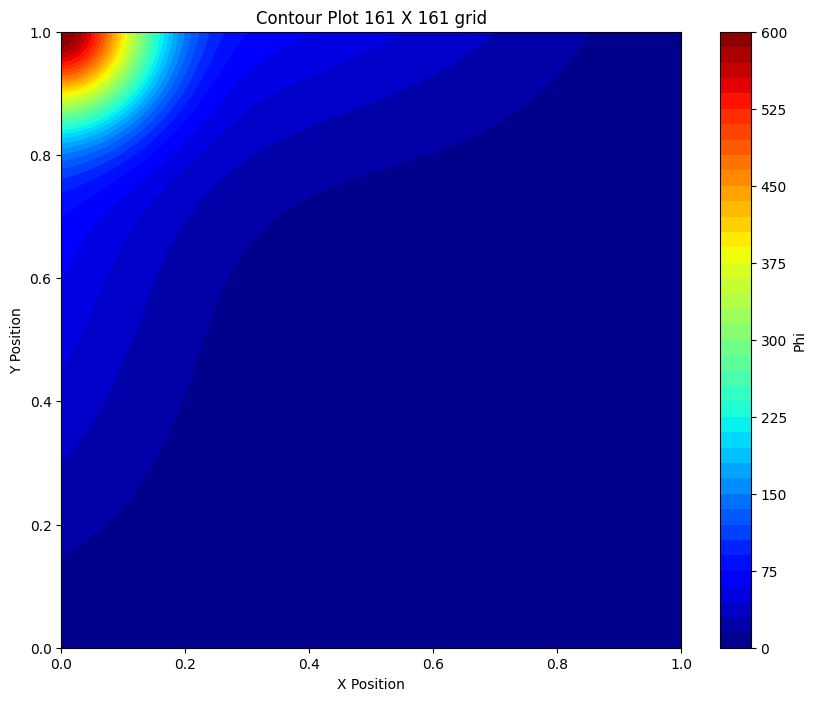

In [25]:
field_plotter(contour_vals_GS[2])

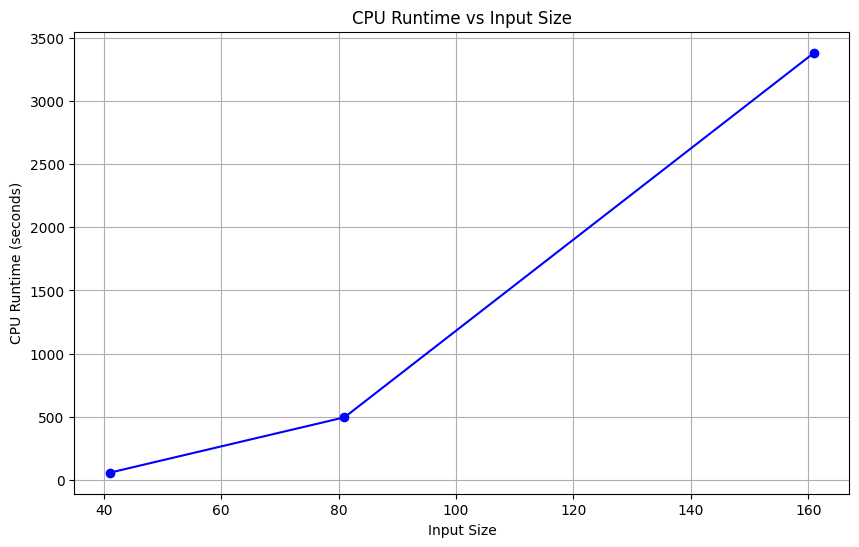

In [26]:
CPU_Time([41,81,161], runtimes_GS)

In [27]:
itterations

[343, 754, 1274]

## Solution using Gauss Siedel [Line By Line] Itterative Method


In [55]:
def LineByLine_RowSweep(Nx, Ny, tol=1e-3):
    dx, dy = 1 / (Nx - 1), 1 / (Ny - 1)
    phi = torch.zeros((Nx, Ny), device="cuda")
    x = torch.linspace(0, 1, Nx, device="cuda")
    y = torch.linspace(0, 1, Ny, device="cuda")
    residuals=[]
    itter_ = 0

    # Boundary conditions
    phi[:, 0] = 100 * x + 500 * torch.exp(-50 * (1 - x) ** 2)
    phi[:, -1] = 500 * torch.exp(-50 * ((1 - x) ** 2 + 1))
    phi[0, :] = 500 * torch.exp(-50 * (1 + y ** 2))
    phi[-1, :] = 100 * (1 - y) + 500 * torch.exp(-50 * y ** 2)
    
    X, Y = torch.meshgrid(x, y)
    S_phi = 50000 * torch.exp(-50 * ((1 - X) ** 2 + Y ** 2)) * (100 * ((1 - X) ** 2 + Y ** 2) - 2)
    
    while True:
        itter_+=1
        phi_old = phi.clone()

        for j in range(1, Ny - 1):
            a = -torch.ones(Nx - 2, device="cuda") / dx**2
            b = 2 * (1 / dx**2 + 1 / dy**2) * torch.ones(Nx - 2, device="cuda")
            c = -torch.ones(Nx - 2, device="cuda") / dx**2
            d = -S_phi[1:-1, j] + (phi[1:-1, j+1] + phi[1:-1, j-1]) / dy**2

            phi[1:-1, j] = TDMA(b, a, c, d)

        residual = torch.norm(phi - phi_old)
        residuals.append(residual.item())
        print(residual)
        if residual / max(residuals) < tol:
            break

    return phi, residuals, itter_x,y
            
    

In [61]:
grid_points = [41,81,161]
runtimes_RS = []
contour_vals_RS = []
itterations_RS = []
residuals_RS = []
for N in grid_points:
    print(f"Running for grid size: {N} x {N}")
    start = time.time()
    phi, residuals,itter_,x,y = LineByLine_RowSweep(N,N)
    end = time.time()
    contour_vals_RS.append((x,y,phi,N))
    runtimes_RS.append(end-start)
    residuals_RS.append(residuals)
    itterations_RS.append(itter_)

tensor(2.7452, device='cuda:0')
tensor(2.7292, device='cuda:0')
tensor(2.7134, device='cuda:0')
tensor(2.6977, device='cuda:0')
tensor(2.6821, device='cuda:0')
tensor(2.6668, device='cuda:0')
tensor(2.6516, device='cuda:0')
tensor(2.6365, device='cuda:0')
tensor(2.6216, device='cuda:0')
tensor(2.6069, device='cuda:0')
tensor(2.5923, device='cuda:0')
tensor(2.5779, device='cuda:0')
tensor(2.5636, device='cuda:0')
tensor(2.5495, device='cuda:0')
tensor(2.5355, device='cuda:0')
tensor(2.5217, device='cuda:0')
tensor(2.5079, device='cuda:0')
tensor(2.4944, device='cuda:0')
tensor(2.4809, device='cuda:0')
tensor(2.4676, device='cuda:0')
tensor(2.4545, device='cuda:0')
tensor(2.4414, device='cuda:0')
tensor(2.4285, device='cuda:0')
tensor(2.4157, device='cuda:0')
tensor(2.4031, device='cuda:0')
tensor(2.3905, device='cuda:0')
tensor(2.3781, device='cuda:0')
tensor(2.3658, device='cuda:0')
tensor(2.3537, device='cuda:0')
tensor(2.3416, device='cuda:0')
tensor(2.3297, device='cuda:0')
tensor(2

In [62]:
len(contour_vals_RS)

3

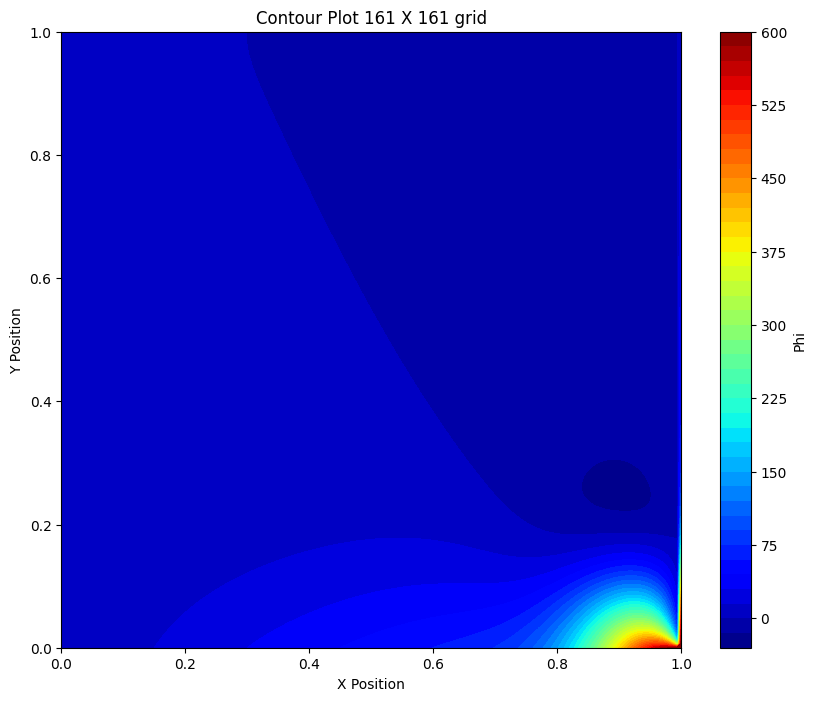

In [64]:
field_plotter(contour_vals_RS[2])

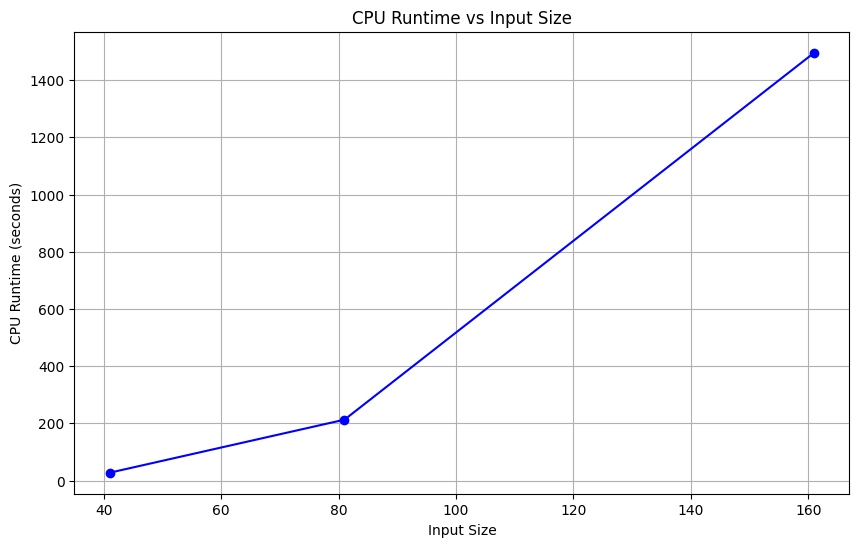

In [65]:
CPU_Time([41,81,161], runtimes_RS)

In [72]:
itterations_RS_final = [120, 232, 408]

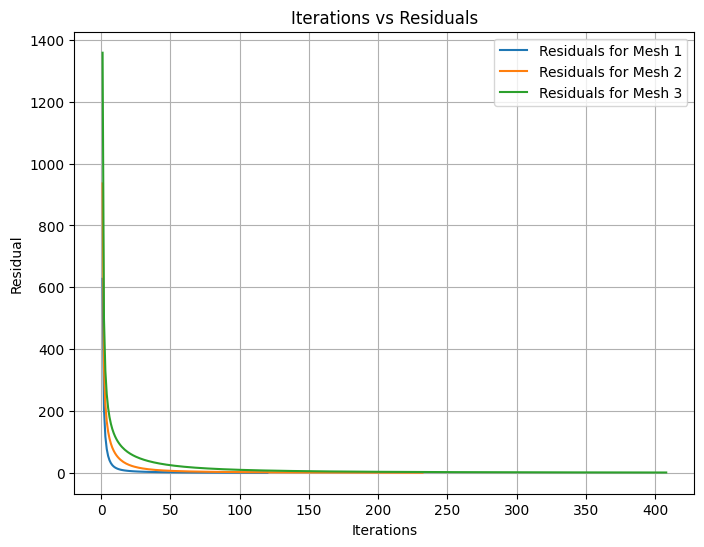

In [79]:
itterVsResidual(itterations_RS, residuals_RS)

## Solution using ADI method

In [68]:
def ADI(Nx, Ny, tol=1e-3):
    dx, dy = 1 / (Nx - 1), 1 / (Ny - 1)
    phi = torch.zeros((Nx, Ny), device="cuda")
    x = torch.linspace(0, 1, Nx, device="cuda")
    y = torch.linspace(0, 1, Ny, device="cuda")
    alpha_x = 0.5 * (dx / dy) ** 2
    alpha_y = 0.5 * (dy / dx) ** 2
    residuals=[]
    itter_x = 0
    itter_y = 0
    itter_ = 0

    # Boundary conditions
    phi[:, 0] = 100 * x + 500 * torch.exp(-50 * (1 - x) ** 2)  
    phi[:, -1] = 500 * torch.exp(-50 * ((1 - x) ** 2 + 1))      
    phi[0, :] = 500 * torch.exp(-50 * (1 + y ** 2))             
    phi[-1, :] = 100 * (1 - y) + 500 * torch.exp(-50 * y ** 2)
    
    X, Y = torch.meshgrid(x, y)
    S_phi = 50000 * torch.exp(-50 * ((1 - X) ** 2 + Y ** 2)) * (100 * ((1 - X) ** 2 + Y ** 2) - 2)
    
    while True:
        itter_+=1
        phi_old = phi.clone()

        for j in range(1, Ny - 1):
            itter_x += 1
            a = -alpha_x * torch.ones(Nx - 2, device="cuda")
            b = (1 + 2 * alpha_x) * torch.ones(nx - 2, device="cuda")
            c = -alpha_x * torch.ones(Nx - 2, device="cuda")
            d = phi[1:-1, j] + 0.5 * alpha_y * (phi[1:-1, j+1] + phi[1:-1, j-1]) - 0.5 * dx**2 * S_phi[1:-1, j]

            phi[1:-1, j] = TDMA(b, a, c, d)
        
        for i in range(1, nx - 1):
            itter_y += 1
            a = -alpha_y * torch.ones(Ny - 2, device=device)
            b = (1 + 2 * alpha_y) * torch.ones(ny - 2, device=device)
            c = -alpha_y * torch.ones(Ny - 2, device=device)
            d = phi[i, 1:-1] + 0.5 * alpha_x * (phi[i+1, 1:-1] + phi[i-1, 1:-1]) - 0.5 * dy**2 * S_phi[i, 1:-1]
            
            phi[i, 1:-1] = TDMA(b, a, c, d)

        residual = torch.norm(phi - phi_old)
        residuals.append(residual.item())

        print(residual)
        if residual / max(residuals) < tol:
            break

    return phi, residuals, itter_, itter_x, itter_y,x,y

In [98]:
import torch

def tdma(a, b, c, d, device="cuda"):
    n = len(d)
    cp = torch.zeros(n, device=device)
    dp = torch.zeros(n, device=device)

    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]

    for i in range(1, n):
        denom = b[i] - a[i] * cp[i - 1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i] * dp[i - 1]) / denom

    x = torch.zeros(n, device=device)
    x[-1] = dp[-1]
    for i in range(n - 2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i + 1]

    return x

def phi_bc(x, y, side):
    if side == 'left':
        return 500 * torch.exp(-50 * (1 + y ** 2))
    elif side == 'right':
        return 100 * (1 - y) + 500 * torch.exp(-50 * y ** 2)
    elif side == 'bottom':
        return 100 * x + 500 * torch.exp(-50 * (1 - x) ** 2)
    elif side == 'top':
        return 500 * torch.exp(-50 * ((1 - x) ** 2 + 1))

def source_term(x, y):
    return 50000 * torch.exp(-50 * ((1 - x) ** 2 + y ** 2)) * (100 * ((1 - x) ** 2 + y ** 2) - 2)

def ADI(Nx, Ny, tol=1e-3):
    dx, dy = 1 / (Nx - 1), 1 / (Ny - 1)
    phi = torch.zeros((Ny, Nx), device="cuda")
    x = torch.linspace(0, 1, Nx, device="cuda")
    y = torch.linspace(0, 1, Ny, device="cuda")
    residuals = []
    itter_x = 0
    itter_y = 0
    itter_ = 0

    # Boundary conditions
    for j in range(Ny):
        phi[j, 0] = phi_bc(0, y[j], 'left')      # Left boundary
        phi[j, -1] = phi_bc(1, y[j], 'right')    # Right boundary

    for i in range(Nx):
        phi[0, i] = phi_bc(x[i], 0, 'bottom')    # Bottom boundary
        phi[-1, i] = phi_bc(x[i], 1, 'top')      # Top boundary

    X, Y = torch.meshgrid(x, y, indexing='ij')
    S_phi = source_term(X, Y)
    
    while True:
        itter_ += 1
        phi_old = phi.clone()

        # X-direction sweep
        for j in range(1, Ny - 1):
            itter_x += 1
            a = -0.5 * torch.ones(Nx - 2, device="cuda") / dx**2
            b = (1 + torch.ones(Nx - 2, device="cuda") / dx**2 + 1 / dy**2) * -1
            c = -0.5 * torch.ones(Nx - 2, device="cuda") / dx**2
            d = phi[1:-1, j].clone()  # Ensure we are cloning to avoid in-place operations
            d -= 0.5 * (phi[1:-1, j+1] + phi[1:-1, j-1]) / dy**2
            d -= dx**2 * S_phi[1:-1, j]

            phi[1:-1, j] = tdma(a, b, c, d)

        # Y-direction sweep
        for i in range(1, Nx - 1):
            itter_y += 1
            a = -0.5 * torch.ones(Ny - 2, device="cuda") / dy**2
            b = (1 + torch.ones(Ny - 2, device="cuda") / dy**2 + 1 / dx**2) * -1
            c = -0.5 * torch.ones(Ny - 2, device="cuda") / dy**2
            d = phi[i, 1:-1].clone()  # Ensure we are cloning to avoid in-place operations
            d -= 0.5 * (phi[i+1, 1:-1] + phi[i-1, 1:-1]) / dx**2
            d -= dy**2 * S_phi[i, 1:-1]

            phi[i, 1:-1] = tdma(a, b, c, d)

        residual = torch.norm(phi - phi_old)
        residuals.append(residual.item())

        print(f"Iteration {itter_}, Residual: {residual.item()}")
        if residual / max(residuals) < tol:
            break

    return phi, residuals, itter_, itter_x, itter_y, x, y


In [99]:
phi_adi, residuals_adi, itters, itters_x, itters_y,x,y = ADI(41,81)

RuntimeError: The size of tensor a (79) must match the size of tensor b (39) at non-singleton dimension 0

In [ ]:
X = x.cpu().numpy()
Y = y.cpu().numpy()
Z = phi_adi.reshape(41,81).cpu().numpy()
X, Y = np.meshgrid(X,Y)
plt.figure(figsize=(10, 8))
contour = plt.contourf(X.T, Y.T, Z, cmap='jet', levels=50)
plt.colorbar(contour, label='Phi')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title(f'Contour Plot 41 X 81 grid')
plt.show()